# Создание и оптимизация ResNet18

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import random
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from PIL import Image

Загрузка логов обучения.

In [2]:
from enum import IntEnum

# user-defined index.
class usid(IntEnum):
    mdl_4x2_ReLU_Adam = 0
    mdl_3x2_ReLU_Adam = 1
    mdl_3x1_ReLU_Adam = 2
    mdl_3x3_ReLU_Adam = 3
    mdl_3x2_Leaky_ReLU_Adam = 4
    mdl_3x2_ELU_Adam = 5
    mdl_3x2_GELU_Adam = 6
    mdl_3x2_ReLU_AdamW = 7

# Имена моделей.
model_names = [e.name for e in usid]

In [3]:
DATA_NUM = len(usid)

log_dir = Path("./train_logs/")
log_data = np.empty(DATA_NUM, dtype='object')
log_data_df = np.empty(DATA_NUM, dtype='object')
model_struct = np.empty(DATA_NUM, dtype='object')
for idx, name in enumerate(model_names):
    with open(log_dir / (name + ".json"), "r") as f:
        log_data[idx] = json.load(f)
        log_data_df[idx] = pd.DataFrame(log_data[idx].get("train_log"))
        model_struct[idx] = log_data[idx].get("model_architecture")

Настройки форматирования графиков.

In [4]:
user_figsize = (10, 6)
user_fontsize = 16
# legend_fontsize: 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'
line_type = ['-', ':']*len(model_names)
plot_mark = ['', 'o']

tab10_colors = [
    '#1f77b4',  # tab:blue
    '#ff7f0e',  # tab:orange
    '#2ca02c',  # tab:green
    '#d62728',  # tab:red
    '#9467bd',  # tab:purple
    '#8c564b',  # tab:brown
    '#e377c2',  # tab:pink
    '#7f7f7f',  # tab:gray
    '#bcbd22',  # tab:olive
    '#17becf']  # tab:cyan

plot_titles = ["Losses", "Accuracy"]
plot_legend = ['train', 'validation']
plot_xlabel = "epoch"
plot_ylabels = ["loss", "accuracy"]
METRIC_NUM = len(plot_titles)

## Часть 3: Поэтапная оптимизация модели

### 3.1. Оптимизация количества каналов

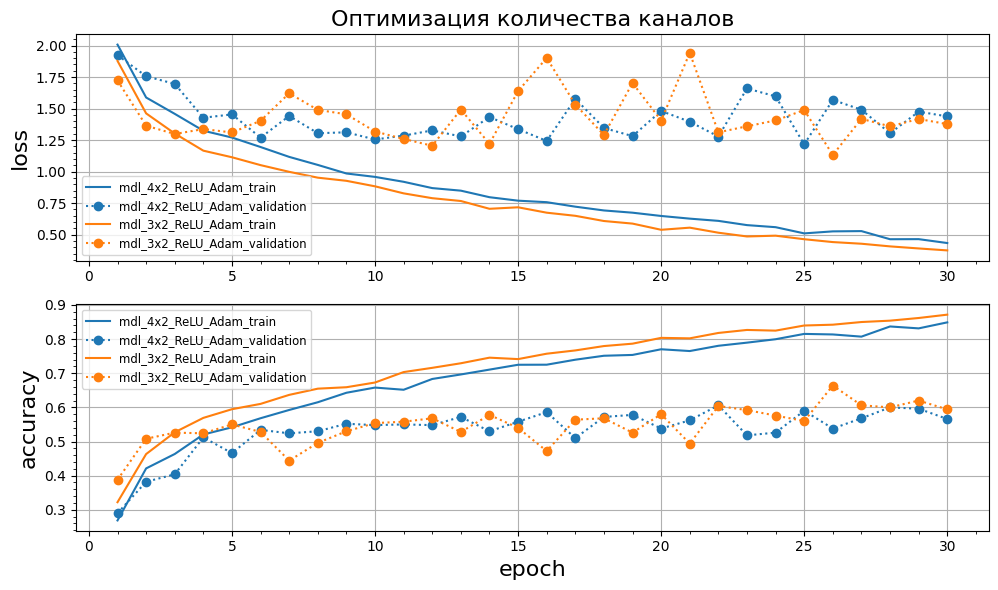

In [6]:
plot_idx = [usid.mdl_4x2_ReLU_Adam.value, usid.mdl_3x2_ReLU_Adam.value]
plot_legend_local = []
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=user_figsize)
for k, ax in enumerate(axs):
    if k == 0:
        ax.set_title("Оптимизация количества каналов", fontsize=user_fontsize)
    else:
        ax.set_xlabel(plot_xlabel, fontsize=user_fontsize)
    for idx in plot_idx:
        for m in range(METRIC_NUM):
            ax.plot(
                log_data_df[idx].iloc[:,0], 
                log_data_df[idx].iloc[:,2*m+k+1],
                marker=plot_mark[m],
                linestyle=line_type[m],
                color=tab10_colors[idx]
                )
        plot_legend_local.extend([model_names[idx] + '_' + tp for tp in plot_legend])
    ax.set_ylabel(plot_ylabels[k], fontsize=user_fontsize)
    ax.legend(plot_legend_local, fontsize='small')
    ax.grid()
    ax.minorticks_on()
    
plt.tight_layout()
plt.savefig('readme_img/loss_acc_4x2_vs_3x2_ReLU_Adam.png', bbox_inches='tight')
plt.show()

### 4.2. Тестирование на test set

In [10]:
# Import Utils.
from torch.utils.data import DataLoader
from src.utils.average_meter import AverageMeter

# Import Datasets.
from src.datasets.TinyImageNetDataset import TinyImageNetDataset

# Import Model.
from src.models.model_structure import customResNet18

Имя модели к загрузке на инференс.

In [11]:
model_name = usid.mdl_3x2_ReLU_Adam.name

In [15]:
config_dir = Path("./src/hyperparameters/")
with open(config_dir / "config.json", "r") as f:
    config_data = json.load(f)

log_dir = Path(config_data.get("checkpoints").get("logs_dir"))
with open(log_dir / (model_name + ".json"), "r") as f:
    full_data = json.load(f)
metadata = full_data.get("metadata")
train_log = full_data.get("train_log")

SEED = metadata.get("seed")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True  # To have ~deterministic results

device = torch.device(metadata.get("device").lower() if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
      
# Model and solver initializing.
img_size = metadata.get('dataset').get('img_size')
net = customResNet18(
    num_classes = metadata.get("dataset").get("class_size"),
    layers_config = metadata.get("model").get("layers_num")*[metadata.get("model").get("block_size")],
    activation = metadata.get("model").get("activation").lower(),
    in_channels = img_size[0],
    layer0_channels = 256 // 2**(metadata.get("model").get("layers_num") - 1)
    )

# Model loading.
checkpoints_dir = Path(config_data.get("checkpoints").get("save_dir"))
checkpoint_file_path_full = checkpoints_dir / (metadata.get("dataset").get("name") + "/best_" + model_name + ".pth")
print('Restoring checkpoint: ', checkpoint_file_path_full)
checkpoint_dict = torch.load(checkpoint_file_path_full, map_location=device)
checkpoint_dict['state_dict'] = {k[len('module.'):] if k.startswith('module.') else k: v for k, v in
                                    checkpoint_dict['state_dict'].items()}
try:
    net.load_state_dict(checkpoint_dict['state_dict'], strict=False)
except RuntimeError as e:
    print(f"State dict loading issues:\n{e}")

net = net.to(device)
if device.type == 'cuda' and torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

model_size = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Model size: {model_size}")

# Data loading.
data_path = Path(config_data.get("data").get("data_path")) / config_data.get("dataset").get("name")
selected_classes = metadata.get("dataset").get("selected_classes")
val_transforms = transforms.Compose([
    transforms.Resize(tuple(img_size[1:])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_loader = DataLoader(
    TinyImageNetDataset(
        data_path,
        split="val",
        transform=val_transforms,
        selected_classes=selected_classes
        ),
    batch_size=metadata.get("batch_size"),
    shuffle=False,
    num_workers=metadata.get("workers"))

print(f"Dataset size: {len(val_loader.dataset)}")

# Model Inference.
net.eval()

loss_fn = nn.CrossEntropyLoss().to(device)

losses = AverageMeter()
accuracy = AverageMeter()

all_preds = []
all_targets = []

with torch.no_grad():
    for data_tuple in tqdm(val_loader, desc="Inference"):

        inputs, gt = data_tuple[0].to(device), data_tuple[1].to(device)

        output = net(inputs)
        
        loss = loss_fn(output, gt)

        predicted = torch.argmax(output.detach(), dim=1)
        correct = gt.detach()

        losses.update(loss.item(), inputs.size(0))
        accuracy.update(float((predicted == correct).sum()) / len(correct), inputs.size(0))

        all_preds.append(predicted.cpu().numpy())
        all_targets.append(correct.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

epoch = checkpoint_dict.get('epoch', 0)

print(f"Inference metrics: Loss: {losses.avg:.4f}, Accuracy: {accuracy.avg:.4f}")
print(f"Loaded metrics:    Loss: {train_log[epoch-1].get('val_loss'):.4f}, Accuracy: {train_log[epoch-1].get('val_accuracy'):.4f}")

Device: cpu
Restoring checkpoint:  checkpoints\tiny-imagenet-200\best_mdl_3x2_ReLU_Adam.pth
Model size: 2789578
Dataset size: 500


Inference: 100%|██████████| 1/1 [00:13<00:00, 13.45s/it]

Inference metrics: Loss: 1.1320, Accuracy: 0.6640
Loaded metrics:    Loss: 1.1321, Accuracy: 0.6640


#### Метрики

In [16]:
df = pd.read_csv(r'src/hyperparameters/selected_classes_id.csv', index_col='wordnet_id')

precision, recall, f1, support = precision_recall_fscore_support(
    all_targets, all_preds, average=None, zero_division=0
)

class_names = df.loc[selected_classes]['classname'].tolist()

metrics_df = pd.DataFrame({
    'wordnet_id': selected_classes,
    'classname': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})

float_cols = ['Precision', 'Recall', 'F1-score']
for col in float_cols:
    metrics_df[col] = metrics_df[col].apply(lambda x: f"{x:.4f}")
print(metrics_df)


  wordnet_id     classname Precision  Recall F1-score  Support
0  n01910747     jellyfish    0.8837  0.7600   0.8172       50
1  n02124075  Egyptian cat    1.0000  0.2600   0.4127       50
2  n03854065    pipe organ    0.7800  0.7800   0.7800       50
3  n02403003            ox    0.5814  0.5000   0.5376       50
4  n09256479    coral reef    0.6338  0.9000   0.7438       50
5  n02415577       bighorn    0.5161  0.6400   0.5714       50
6  n02814533   beach wagon    0.6136  0.5400   0.5745       50
7  n04285008     sport car    0.5970  0.8000   0.6838       50
8  n03796401    moving van    0.6964  0.7800   0.7358       50
9  n04254777          sock    0.6667  0.6800   0.6733       50


Вставляем таблицу в `README.md`.

In [17]:
import re
markdown_table = metrics_df.to_markdown(index=False, disable_numparse=True, tablefmt="github")

with open('README.md', 'r', encoding='utf-8') as f:
    content = f.read()

header = "### 4.2: Тестирование на test set"
escaped_header = re.escape(header)
pattern = rf"({escaped_header}\s*\n)(?:^(?!#).*$\n?)*"
replacement = rf"\1{markdown_table}\n\n"

updated_content = re.sub(pattern, replacement, content, flags=re.MULTILINE)

with open('README.md', 'w', encoding='utf-8') as f:
    f.write(updated_content)

Confusion Matrix.

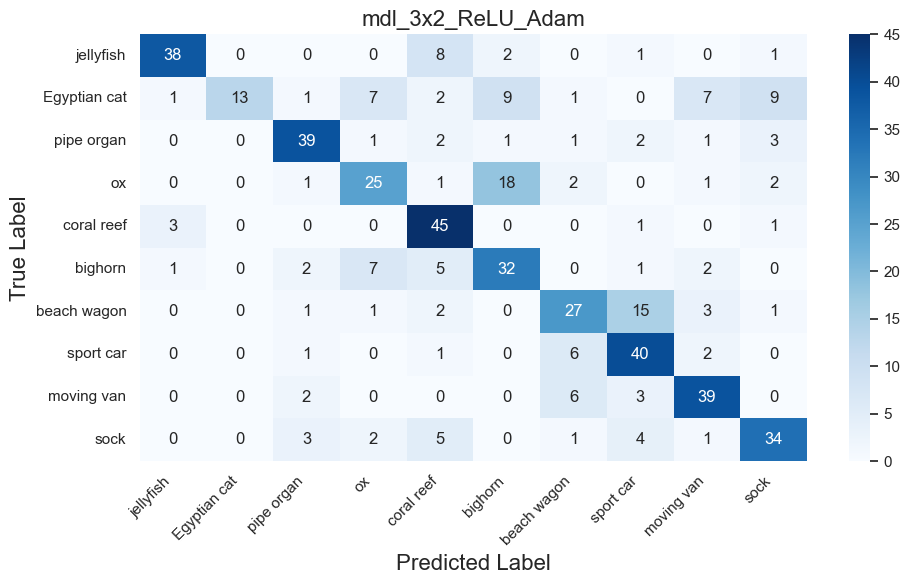

In [18]:
cm = confusion_matrix(all_targets, all_preds, labels=range(len(selected_classes)))
plt.figure(figsize=user_figsize)
sns.set(font_scale=1.0)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'shrink': 1.0}
)
plt.title(model_name, fontsize=user_fontsize)
plt.xlabel('Predicted Label', fontsize=user_fontsize)
plt.ylabel('True Label', fontsize=user_fontsize)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('readme_img/confusion_matrix.png', bbox_inches='tight')
plt.show()

### 4.3. Визуальный анализ

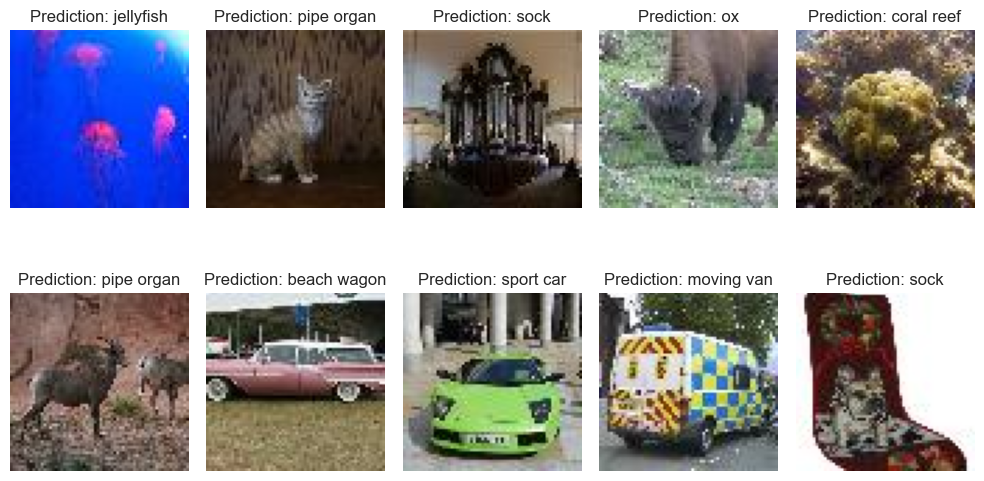

In [19]:
img_dir = Path('./datasets/tiny-imagenet-200/test/images')

images = []
true_labels = []
predicted_labels = []

for _, row in df.iterrows():
    img_path = row['testsample']
    true_label = row['classname']
    
    # Загрузка изображения
    img_pil = Image.open(img_dir / img_path).convert('RGB')
    img_tensor = val_transforms(img_pil).unsqueeze(0).to(device)
    
    # Предсказание
    with torch.no_grad():
        output = net(img_tensor)
        pred = torch.argmax(output, dim=1).item()
    
    images.append(img_pil)
    true_labels.append(true_label)
    predicted_labels.append(pred)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=user_figsize)
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(images[i])
    # Можно показать либо истинную метку, либо предсказанную
    # Здесь — предсказанная, но вы можете заменить на true_labels[i]
    label_to_show = predicted_labels[i]
    if class_names:
        label_to_show = class_names[label_to_show]
    axes[i].set_title(f'Prediction: {label_to_show}')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('readme_img/test_demo.png', bbox_inches='tight')

plt.show()